In [ ]:
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Resize((227, 227)),
                                               torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])
                                           ]))

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Resize((227, 227)),
                                               torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])
                                           ]))


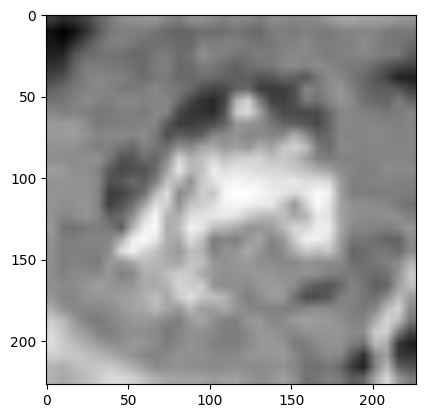

In [ ]:
plt.imshow(train_dataset[0][0][0], cmap="gray")


In [ ]:
class AlexNet(torch.nn.Module):
    def __init__(self, num_classes):
      super().__init__()
      self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=96, stride=4, kernel_size=11)
      self.batch1 = torch.nn.BatchNorm2d(96)
      self.pooling1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

      self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, stride=1, padding=2, kernel_size=5)
      self.batch2 = torch.nn.BatchNorm2d(256)
      self.pooling2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

      self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, stride=1, padding=1, kernel_size=3)
      self.batch3 = torch.nn.BatchNorm2d(384)
      self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, stride=1, padding=1, kernel_size=3)
      self.batch4 = torch.nn.BatchNorm2d(384)
      self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, stride=1, padding=1, kernel_size=3)
      self.batch5 = torch.nn.BatchNorm2d(256)
      self.pooling3 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

      self.dp1 = torch.nn.Dropout(0.5)
      self.fc1 = torch.nn.Linear(in_features=9216, out_features=4096)
      self.dp2 = torch.nn.Dropout(0.5)
      self.fc2 = torch.nn.Linear(in_features=4096, out_features=4096)
      self.fc3 = torch.nn.Linear(in_features=4096, out_features=num_classes)

    def forward(self, input):

      out_conv1 = self.conv1(input)
      out_batch1 = torch.nn.functional.relu(self.batch1(out_conv1))
      out_pooling1 = self.pooling1(out_batch1)

      out_conv2 = self.conv2(out_pooling1)
      out_batch2 = torch.nn.functional.relu(self.batch2(out_conv2))
      out_pooling2 = self.pooling2(out_batch2)

      out_conv3 = self.conv3(out_pooling2)
      out_batch3 = torch.nn.functional.relu(self.batch3(out_conv3))
      out_conv4 = self.conv4(out_batch3)
      out_batch4 = torch.nn.functional.relu(self.batch4(out_conv4))
      out_conv5 = self.conv5(out_batch4)
      out_batch5 = torch.nn.functional.relu(self.batch5(out_conv5))
      out_pooling3 = self.pooling3(out_batch5)

      flatten = out_pooling3.view(out_pooling3.shape[0], -1)
      out_dp1 = self.dp1(flatten)
      out_fc1 = torch.nn.functional.relu(self.fc1(out_dp1))
      out_dp2 = self.dp2(out_fc1)
      out_fc2 = torch.nn.functional.relu(self.fc2(out_dp2))
      out = self.fc3(out_fc2)
      return out

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"running on: {device}")

train_data_loader = DataLoader(dataset=train_dataset, batch_size=64)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=64)
criterion = torch.nn.CrossEntropyLoss()

epochs_num = 20
learning_rate = 1e-4
total_step = len(train_data_loader)
model = AlexNet(num_classes=10).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
print(120 * '-')



for epoch in range(epochs_num):
  for i, (images, labels) in enumerate(tqdm(train_data_loader)):
    images = images.to(device=device)
    labels = labels.to(device=device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  print(f"Epoch [{epoch+1}/{epochs_num}], Step [{i+1}/{total_step}], Loss: {loss.item()}")


  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_data_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      del images, labels, outputs

    print(f"Accuracy of the network on the {5000} validation images: {100*correct/total}%")


  print(120 * '-')


running on: cuda
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:48<00:00, 16.19it/s]


Epoch [1/20], Step [782/782], Loss: 1.3169174194335938
Accuracy of the network on the 5000 validation images: 65.78%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:55<00:00, 14.16it/s]


Epoch [2/20], Step [782/782], Loss: 1.3477863073349
Accuracy of the network on the 5000 validation images: 71.98%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:55<00:00, 14.02it/s]


Epoch [3/20], Step [782/782], Loss: 0.7971459627151489
Accuracy of the network on the 5000 validation images: 74.31%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.85it/s]


Epoch [4/20], Step [782/782], Loss: 0.875773549079895
Accuracy of the network on the 5000 validation images: 75.25%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.88it/s]


Epoch [5/20], Step [782/782], Loss: 1.0102065801620483
Accuracy of the network on the 5000 validation images: 77.33%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.85it/s]


Epoch [6/20], Step [782/782], Loss: 0.9840479493141174
Accuracy of the network on the 5000 validation images: 78.04%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.73it/s]


Epoch [7/20], Step [782/782], Loss: 0.8761303424835205
Accuracy of the network on the 5000 validation images: 77.85%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.73it/s]


Epoch [8/20], Step [782/782], Loss: 0.5290226936340332
Accuracy of the network on the 5000 validation images: 79.14%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:57<00:00, 13.58it/s]


Epoch [9/20], Step [782/782], Loss: 0.3927457928657532
Accuracy of the network on the 5000 validation images: 80.39%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:57<00:00, 13.70it/s]


Epoch [10/20], Step [782/782], Loss: 0.3314219117164612
Accuracy of the network on the 5000 validation images: 80.19%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:58<00:00, 13.46it/s]


Epoch [11/20], Step [782/782], Loss: 0.23176953196525574
Accuracy of the network on the 5000 validation images: 80.27%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.79it/s]


Epoch [12/20], Step [782/782], Loss: 0.4323214292526245
Accuracy of the network on the 5000 validation images: 80.85%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:57<00:00, 13.63it/s]


Epoch [13/20], Step [782/782], Loss: 0.2828138470649719
Accuracy of the network on the 5000 validation images: 80.78%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:57<00:00, 13.65it/s]


Epoch [14/20], Step [782/782], Loss: 0.1705470085144043
Accuracy of the network on the 5000 validation images: 80.57%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.75it/s]


Epoch [15/20], Step [782/782], Loss: 0.30514219403266907
Accuracy of the network on the 5000 validation images: 81.54%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [03:09<00:00,  4.13it/s]


Epoch [16/20], Step [782/782], Loss: 0.17851893603801727
Accuracy of the network on the 5000 validation images: 81.88%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.90it/s]


Epoch [17/20], Step [782/782], Loss: 0.13024228811264038
Accuracy of the network on the 5000 validation images: 82.06%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:56<00:00, 13.88it/s]


Epoch [18/20], Step [782/782], Loss: 0.3404635190963745
Accuracy of the network on the 5000 validation images: 82.57%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:57<00:00, 13.57it/s]


Epoch [19/20], Step [782/782], Loss: 0.16033099591732025
Accuracy of the network on the 5000 validation images: 82.57%
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 782/782 [00:57<00:00, 13.67it/s]


Epoch [20/20], Step [782/782], Loss: 0.08172997832298279
Accuracy of the network on the 5000 validation images: 82.55%
------------------------------------------------------------------------------------------------------------------------
